In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.keras import TqdmCallback

In [43]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat = df_train.loc[:, df_train.columns != "SalePrice"].select_dtypes(include=['object']).fillna("None")
enc = OneHotEncoder(handle_unknown='ignore').fit(cat)
cat = enc.transform(cat).toarray()
cat_sub = enc.transform(df_test.select_dtypes(include=['object']).fillna("None")).toarray()

In [45]:
X = df_train.loc[:, df_train.columns != "SalePrice"].select_dtypes(include=['float64', 'float', 'int']).fillna(df_train.mean()).to_numpy()
X_sub = df_test.select_dtypes(include=['float64', 'float', 'int']).fillna(df_test.mean()).to_numpy()
y = df_train["SalePrice"].to_numpy()

C:\Users\Adrien.Bouvais\AppData\Local\Temp\ipykernel_23072\1276083086.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X = df_train.loc[:, df_train.columns != "SalePrice"].select_dtypes(include=['float64', 'float', 'int']).fillna(df_train.mean()).to_numpy()
C:\Users\Adrien.Bouvais\AppData\Local\Temp\ipykernel_23072\1276083086.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  X_sub = df_test.select_dtypes(include=['float64', 'float', 'int']).fillna(df_test.mean()).to_numpy()


In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X_sub = sc.transform(X_sub)

In [47]:
X = np.concatenate((X, cat), axis = 1)
X_sub = np.concatenate((X_sub, cat_sub), axis = 1)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [49]:
from keras import Model, Input
from keras.layers import Dense, Dropout

number_of_input = X_train.shape[1]

input_tensor = Input(shape=(number_of_input))
x = Dense(512, activation='relu')(input_tensor)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_tensor = Dense(1)(x)

model = Model(inputs=input_tensor, outputs=output_tensor)
model.compile(optimizer='adam', loss='mse')

model.summary()

del number_of_input, x, input_tensor, output_tensor

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 304)]             0         
                                                                 
 dense_12 (Dense)            (None, 512)               156160    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               262656    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0   

In [50]:
history = model.fit(x=X_train,y=y_train,
          validation_data=(X_val,y_val),
          batch_size=128,epochs=100, 
          verbose=0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

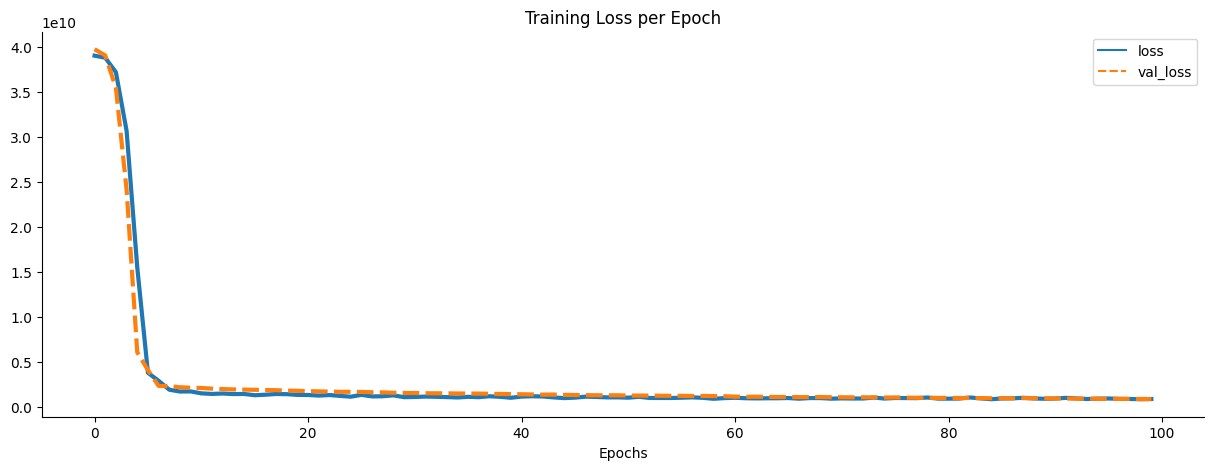

In [51]:
losses = pd.DataFrame(history.history)

plt.figure(figsize=(15,5))
sns.lineplot(data=losses,lw=3)
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training Loss per Epoch')
sns.despine()

In [52]:
prediction = model.predict(X_sub)
prediction = prediction.reshape(1459, 1)
ids = df_test["Id"].to_numpy().reshape((1459, 1))
sub = np.concatenate((ids, prediction), axis = 1)
sub_df = pd.DataFrame(sub, columns=["Id", "SalePrice"])
sub_df["Id"] = sub_df["Id"].astype("int")
sub_df.to_csv("submission.csv", index = False)

46/46 [==============================] - 0s 1ms/step
